In [26]:
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Retrieve data
Read data as JSON

In [2]:
with open('./data/train.json', 'r') as file:
    data = json.load(file)

# Inspect data

Total numerical information

In [3]:
cuisine = set()
ingredients = set()

for dish in data:
    cuisine.add(dish['cuisine'])
    ingredients.update(dish['ingredients'])

print('Total number of data entries:', len(data))

# print(cuisine)
print('Total number of classes:', len(cuisine))

# print(ingredients)
print('Total number of input parameters:', len(ingredients))

labelsToCode = {}
codeToLabel = {}
for elm in cuisine:
    if elm not in labelsToCode:
        code = len(codeToLabel)
        labelsToCode[elm] = code
        codeToLabel[len(codeToLabel)] = elm

inputsToCode = {}
for elm in ingredients:
    if elm not in inputsToCode:
        inputsToCode[elm] = len(inputsToCode)


Total number of data entries: 39774
Total number of classes: 20
Total number of input parameters: 6714


## Check classes balance

<Axes: xlabel='Cuisine'>

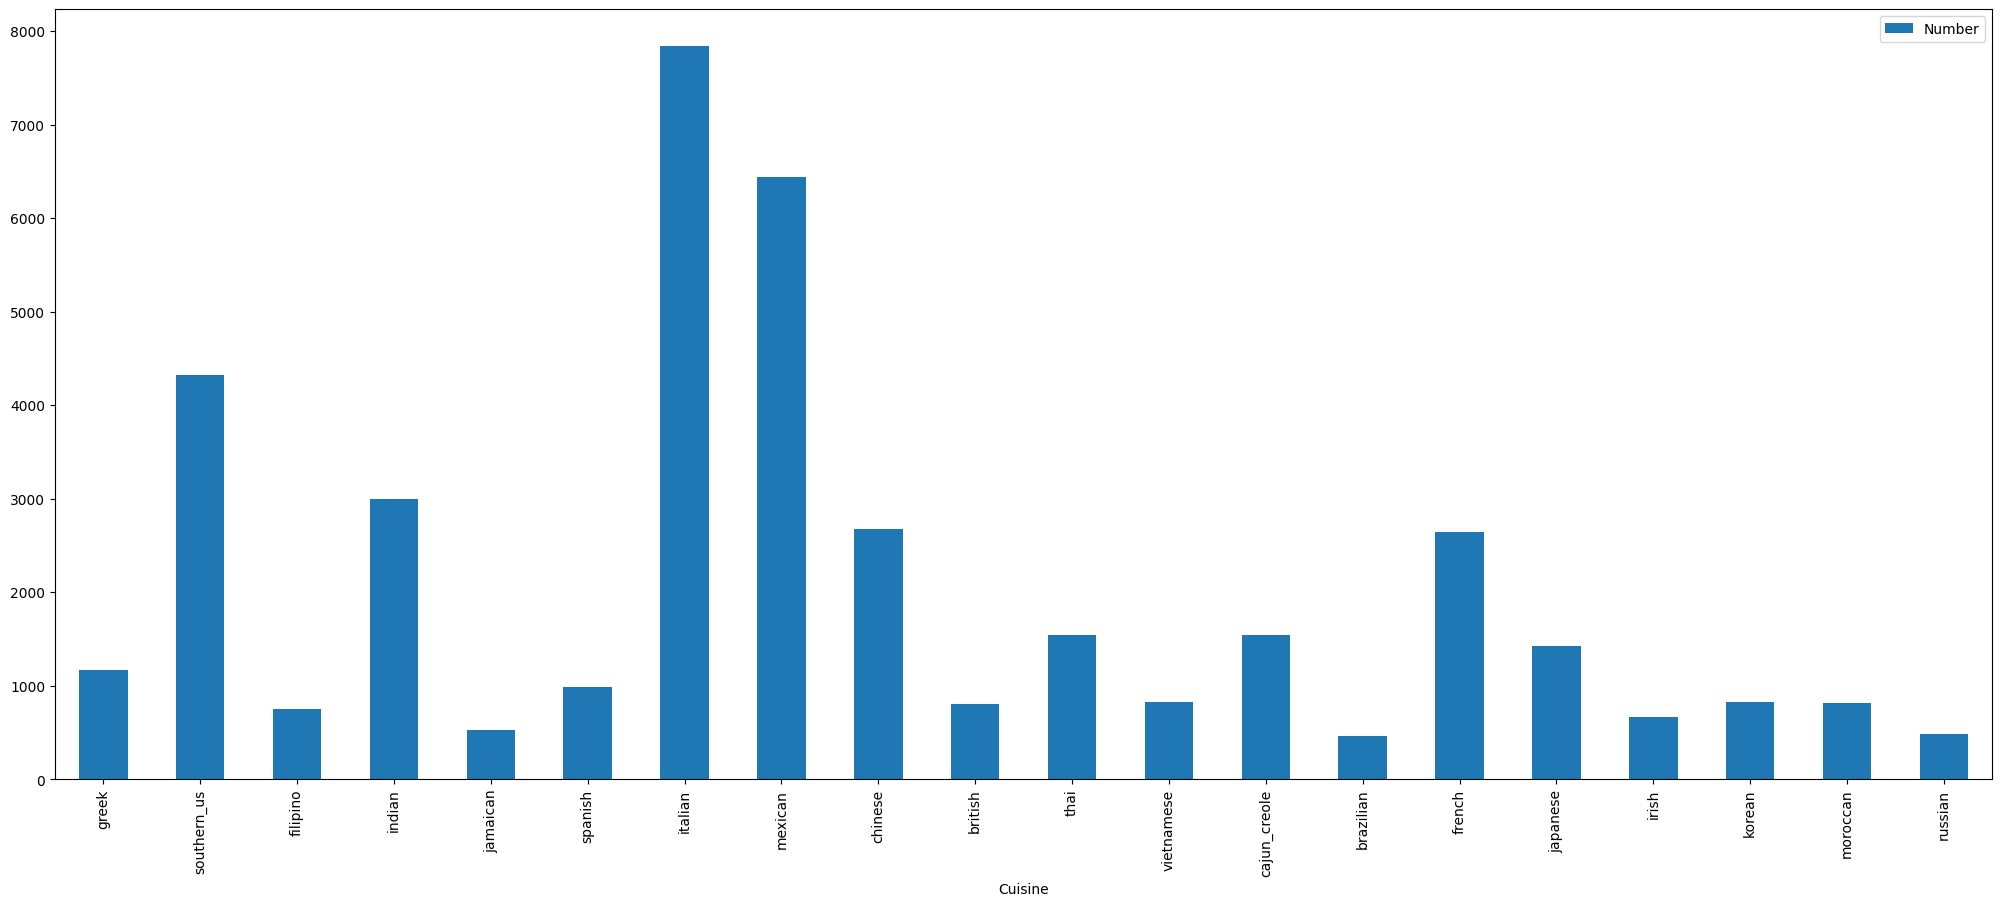

In [4]:
stats = {}
for dish in data:
    label = dish['cuisine']
    if label not in stats:
        stats[label] = 0
    stats[dish['cuisine']] += 1

min = None
for val in stats.values():
    if min is None or val < min:
        min = val

result = pd.DataFrame({'Cuisine': stats.keys(), 'Number': stats.values()})
result.plot(kind = 'bar', x = 'Cuisine', y = 'Number', figsize=(25, 10))

# Transform data

* Map predictors to binary descriptors {0, 1}
* Map labels to {0, 1, ..., 19}

In [5]:
x = []
y = np.array([], dtype=int)

for dish in data:
    descriptors = np.zeros(len(ingredients), dtype=int)
    for elm in dish['ingredients']:
        code = inputsToCode[elm]
        descriptors[code] = 1
    x.append(descriptors)
    y = np.append(y, labelsToCode[dish['cuisine']])

x = np.array(x)

## Split data into train/test sets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
print('Number of train entires: ', len(x_train))
print('Number of test entries:', len(x_test))

Number of train entires:  31819
Number of test entries: 7955


In [7]:
x_train_reduced_1, x_train_reduced_2, y_train_reduced_1, y_train_reduced_2 = train_test_split(x_train, y_train, train_size=0.6, test_size=0.2)
print('Number of reduced (1) entires: ', len(x_train_reduced_1))
print('Number of reduced (2) entries:', len(x_train_reduced_2))

Number of reduced (1) entires:  19091
Number of reduced (2) entries: 6364


### Define response visualization function

In [8]:
def printYStats(y):
    stats = {}
    for elm in y:
        label = codeToLabel[elm]
        if label not in stats:
            stats[label] = 0
        stats[label] += 1
    print(stats)
    result = pd.DataFrame({'Class': stats.keys(), 'Number': stats.values()})
    result.plot(kind = 'bar', x = 'Class', y = 'Number', figsize=(25, 10))

## Check train/test sets stratification

              Train  Test
brazilian       387    80
chinese        2131   542
mexican        5130  1308
filipino        605   150
french         2099   547
moroccan        621   200
southern_us    3448   872
indian         2409   594
italian        6321  1517
thai           1215   324
japanese       1146   277
korean          665   165
vietnamese      674   151
cajun_creole   1221   325
jamaican        424   102
british         651   153
greek           973   202
russian         404    85
spanish         770   219
irish           525   142


<Axes: >

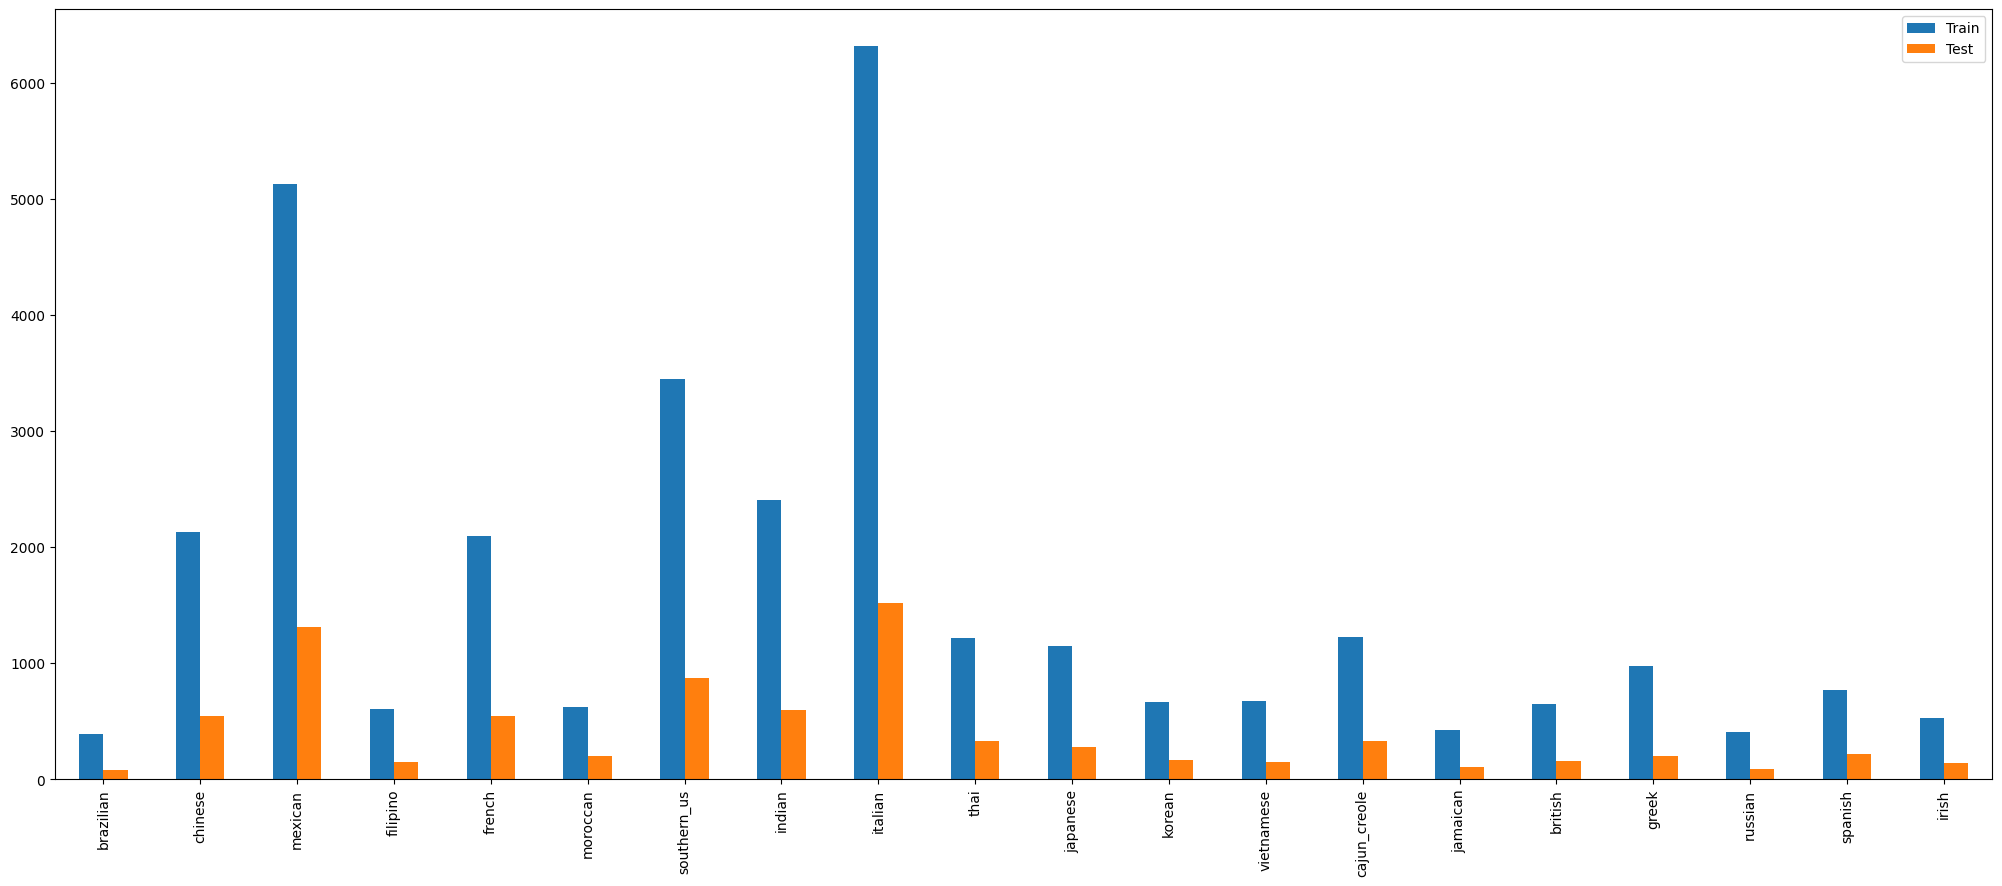

In [9]:
stats = {}
for elm in y_train:
    label = codeToLabel[elm]
    if label not in stats:
        stats[label] = [0, 0]
    stats[label][0] += 1

for elm in y_test:
    label = codeToLabel[elm]
    if label not in stats:
        stats[label] = [0, 0]
    stats[label][1] += 1

result = pd.DataFrame(stats).transpose()
result.rename(columns={0:'Train', 1:'Test'}, inplace=True)
print(result)
result.plot(kind='bar', figsize=(25, 10))

## Fit model to train data

* Use `class_wight='balanced'` for class balancing
* Use different types of models to compare them
* Use different datasets sizes to demonstrate accuracy-training data size dependency

In [51]:
modelLR = LogisticRegression(max_iter=10_000, class_weight='balanced').fit(x_train, y_train)

In [20]:
modelRF = RandomForestClassifier(n_estimators=1000, class_weight='balanced', verbose=1).fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 18.7min finished


In [12]:
modelLR_r1 = LogisticRegression(max_iter=100, class_weight='balanced').fit(x_train_reduced_1, y_train_reduced_1)
modelLR_r2 = LogisticRegression(max_iter=100, class_weight='balanced').fit(x_train_reduced_2, y_train_reduced_2)
modelRF_r1 = RandomForestClassifier(class_weight='balanced').fit(x_train_reduced_1, y_train_reduced_1)
modelRF_r2 = RandomForestClassifier(class_weight='balanced').fit(x_train_reduced_2, y_train_reduced_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\herman-rog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[P

In [52]:
lr_s = modelLR.score(x_test, y_test)
lr_s_r1 = modelLR_r1.score(x_test, y_test)
lr_s_r2 = modelLR_r2.score(x_test, y_test)

rf_s = modelRF.score(x_test, y_test)
rf_s_r1 = modelRF_r1.score(x_test, y_test)
rf_s_r2 = modelRF_r2.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


<Axes: title={'center': 'Models Accuracy (on training dataset size)'}>

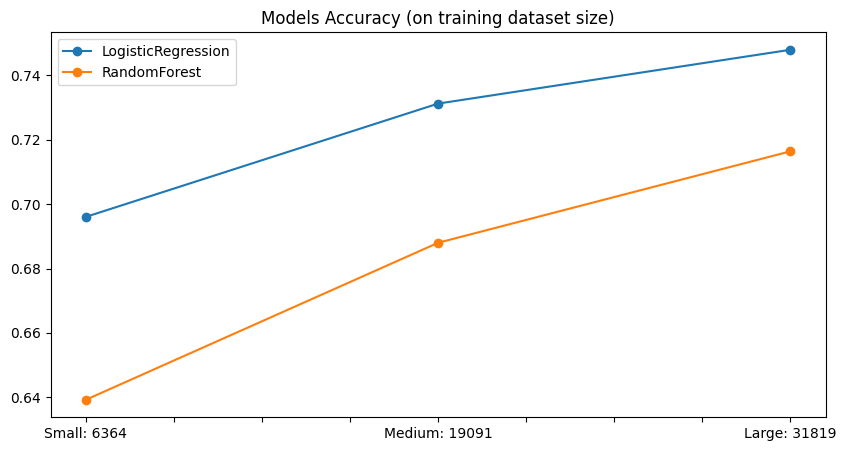

In [53]:
result = pd.DataFrame({'LogisticRegression': [lr_s_r2, lr_s_r1, lr_s], 'RandomForest': [rf_s_r2, rf_s_r1, rf_s]})
result.rename(
    index={
        0: 'Small: ' + str(len(x_train_reduced_2)), 
        1: 'Medium: ' + str(len(x_train_reduced_1)), 
        2: 'Large: ' + str(len(x_train))
    }, 
    inplace=True
)
result.plot(kind='line', rot=0, figsize=(10, 5), style='o-', title='Models Accuracy (on training dataset size)')



In [54]:
y_predicted = modelLR.predict(x_test)

In [55]:
print('Classification Report (Logistic Regression):\n', classification_report(y_test, y_predicted, target_names=labelsToCode.keys()))

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

       greek       0.59      0.77      0.67       202
     mexican       0.94      0.87      0.90      1308
     chinese       0.85      0.78      0.81       542
      korean       0.74      0.85      0.79       165
cajun_creole       0.71      0.76      0.73       325
      indian       0.87      0.85      0.86       594
    japanese       0.75      0.72      0.73       277
     spanish       0.44      0.61      0.51       219
   brazilian       0.45      0.70      0.55        80
        thai       0.82      0.71      0.76       324
     russian       0.30      0.54      0.38        85
    filipino       0.55      0.69      0.61       150
    jamaican       0.61      0.71      0.65       102
  vietnamese       0.56      0.68      0.61       151
 southern_us       0.79      0.69      0.74       872
       irish       0.45      0.63      0.52       142
      french       0.56      0.62  

In [61]:
print('Confusion Matrix (Logistic Regression):')
pd.DataFrame(confusion_matrix(y_test, y_predicted)).rename(columns=codeToLabel, index=codeToLabel)

Confusion Matrix (Logistic Regression):


,greek,mexican,chinese,korean,cajun_creole,indian,japanese,spanish,brazilian,thai,russian,filipino,jamaican,vietnamese,southern_us,irish,french,moroccan,british,italian
greek,155,2,0,0,0,2,0,10,0,0,4,0,0,0,1,2,7,3,2,14
mexican,9,1134,3,2,16,4,0,28,21,3,9,4,6,2,28,5,16,7,4,7
chinese,0,2,423,17,1,5,26,1,1,13,3,19,3,19,1,1,3,0,1,3
korean,0,0,9,140,0,0,9,0,0,0,1,3,0,2,0,0,0,0,1,0
cajun_creole,1,4,1,0,247,1,0,4,4,0,7,0,1,0,30,1,8,0,3,13
indian,8,12,1,1,0,504,14,5,6,3,6,1,2,3,1,3,3,17,3,1
japanese,2,1,16,10,1,22,199,2,0,1,5,6,1,2,1,1,1,1,4,1
spanish,7,9,0,0,7,3,0,134,6,1,2,4,2,1,4,1,17,7,1,13
brazilian,0,2,0,0,2,1,0,2,56,3,3,2,1,1,5,1,0,0,1,0
thai,1,3,20,9,0,4,2,3,4,230,0,6,3,38,0,1,0,0,0,0
